In [1]:
!python -m pip install --upgrade pip
!pip install tqdm

In [2]:
import tqdm
from concurrent.futures import ProcessPoolExecutor

In [4]:
import sys, os

# Adding src to path
sys.path.append(os.getcwd() + '\src')

# Performance Visualization of Jakobsen's Algorithm

## Setting Paramaters and Getting Plaintext

In [5]:
# Common Values
wordLengths = [10, 15, 20, 25, 50, 75, 100, 200, 300, 400, 500]
numberOfTrials = 100

In [6]:
from utils.utils import selectPlainText

def getPlaintextSamples(length, numberOfSamples):

    plaintextSamples = []

    for _ in range(numberOfSamples):
        plaintextSamples.append(selectPlainText(length))

    return plaintextSamples

In [6]:
plaintextSamples = {}
for length in wordLengths:
    print("Getting plaintext samples of length", length, end = '\r')
    plaintextSamples[length] = getPlaintextSamples(length, numberOfTrials)

print(str(numberOfTrials) +" plaintext samples gathered for lengths", ", ".join([str(word) for word in wordLengths]))

100 plaintext samples gathered for lengths 10, 15, 20, 25, 50, 75, 100, 200, 300, 400, 500


## Computing Data

In [8]:
# Helper function to get results
def getResults(decryptionFunction, plaintextTests, spacesRemoved, max_workers=12):

    # Getting results of Jakobsen's with spaced queries
    results = {}
    executor = ProcessPoolExecutor(max_workers=max_workers)

    for length, plaintextList in plaintextTests.items():
        jobQueue = []
        results[length] = []

        for plaintext in plaintextList:
            jobQueue.append(executor.submit(decryptionFunction, plaintext, length, spacesRemoved))

        for future in tqdm.tqdm(jobQueue, desc="Processing trials of length " + str(length)):
            results[length].append(future.result())

    executor.shutdown()
    return results

In [9]:
# Getting results of standard jakobsensAlgorithm on spaced plaintexts
from jakobsensAlgorithm import testJakobsens
resultsSpacedJakobsens = getResults(testJakobsens, plaintextSamples, False, max_workers=12)

Processing trials of length 500: 100%|██████████| 100/100 [00:08<00:00, 11.78it/s]


In [9]:
print(resultsSpacedJakobsens[500][:10])

[(26, 1.0), (26, 1.0), (26, 1.0), (24, 1.0), (26, 1.0), (26, 1.0), (26, 1.0), (24, 0.999002493765586), (24, 1.0), (26, 1.0)]


In [10]:
resultsUnspacedJakobsens = getResults(testJakobsens, plaintextSamples, True, max_workers=12)

Processing trials of length 10:   0%|          | 0/100 [00:00<?, ?it/s]

Processing trials of length 500: 100%|██████████| 100/100 [00:17<00:00,  5.85it/s]


In [9]:
# Helper function to get results
def getResultsRandomRestart(decryptionFunction, plaintextTests, numRestarts, spacesRemoved, max_workers=12):

    # Getting results of Jakobsen's with spaced queries
    results = {}
    executor = ProcessPoolExecutor(max_workers=max_workers)

    for length, plaintextList in plaintextTests.items():
        jobQueue = []
        results[length] = []

        for plaintext in plaintextList:
            jobQueue.append(executor.submit(decryptionFunction, plaintext, length, numRestarts=numRestarts, spacesRemoved=spacesRemoved))

        for future in tqdm.tqdm(jobQueue, desc="Processing trials of length " + str(length)):
            results[length].append(future.result())

    executor.shutdown()
    return results

In [12]:
from jakobsensAlgorithmRandomStart import testJakobsensRandomRestart

# Getting results of standard jakobsensAlgorithm on unspaced plaintexts
#print(plaintextSamples[10][0])
#print(testJakobsensRandomRestart(plaintextSamples[10][0], 10))
resultsUnspacedJakobsensRandomRestart = getResultsRandomRestart(testJakobsensRandomRestart, plaintextSamples, 5, True, max_workers=12)

Processing trials of length 500: 100%|██████████| 100/100 [00:44<00:00,  2.24it/s]


In [25]:
from jakobsensAlgorithmRandomStart import testJakobsensRandomRestart
resultsSpacedJakobsensRandomRestart = getResultsRandomRestart(testJakobsensRandomRestart, plaintextSamples, 5, False, max_workers=12)

Processing trials of length 10:   0%|          | 0/100 [00:00<?, ?it/s]

Processing trials of length 500: 100%|██████████| 100/100 [00:43<00:00,  2.32it/s]


In [12]:
from trigramJakobsens import testTrigramJakobsensAlgorithm
resultsSpacedBaseTrigram = getResults(testTrigramJakobsensAlgorithm, plaintextSamples, False, max_workers=12)

Processing trials of length 500: 100%|██████████| 100/100 [03:24<00:00,  2.05s/it]


In [19]:
from trigramJakobsens import testJakobsensTrigramRestart
resultsSpacedTrigram = getResultsRandomRestart(testJakobsensTrigramRestart, plaintextSamples, 5, False, max_workers=12)

Processing trials of length 500: 100%|██████████| 100/100 [00:58<00:00,  1.72it/s]


In [15]:
resultsUnspacedTrigram = getResultsRandomRestart(testJakobsensTrigramRestart, plaintextSamples, 5, True, max_workers=12)

Processing trials of length 500: 100%|██████████| 100/100 [00:57<00:00,  1.73it/s]


In [16]:
#from jakobsensAlgorithmRandomStart import testJakobsensRandomRestartCheating
#resultsSpacedCheating = getResultsRandomRestart(testJakobsensRandomRestartCheating, plaintextSamples, 5, False, max_workers=30)

In [17]:
#from biTriJakobsen import testBiTriJakobsens
#resultsUnspacedBiTrigram = getResults(testBiTriJakobsens, plaintextSamples, True, max_workers=60)

## Formatting and Aggregating Results 

In [12]:
def formatResults(resultsDictionary):

    formattedResultsDictionary = {}
    for length, results in resultsDictionary.items():
        letterResults = [lettersFound for lettersFound, _ in results]
        percentResults = [percentDecoded for _, percentDecoded in results]
        formattedResultsDictionary[length] = (sum(letterResults)/len(letterResults), sum(percentResults)/len(percentResults))
    
    return formattedResultsDictionary

In [27]:
formattedResultsSpacedJakobsens = formatResults(resultsSpacedJakobsens)
#formattedResultsUnspacedJakobsens = formatResults(resultsUnspacedJakobsens)
formattedResultsSpacedBaseTrigram = formatResults(resultsSpacedBaseTrigram)
formattedResultsSpacedJakobsensRandomRestart = formatResults(resultsSpacedJakobsensRandomRestart)
#formattedResultsUnspacedJakobsensRandomRestart = formatResults(resultsUnspacedJakobsensRandomRestart)
formattedResultsSpacedTrigram = formatResults(resultsSpacedTrigram)
#formattedResultsUnspacedTrigram = formatResults(resultsUnspacedTrigram)

## Visualizations

In [20]:
# TODO: Create a function to make boxplots

In [21]:
resultsDictionaries = [formattedResultsSpacedJakobsens, formattedResultsUnspacedJakobsens, formattedResultsSpacedJakobsensRandomRestart, formattedResultsUnspacedJakobsensRandomRestart, formattedResultsSpacedTrigram, formattedResultsUnspacedTrigram]
resultsLabels = ["Spaced Jakobsens", "Spaceless Jakobsons", "Spaced Random Restart", "Spaceless Random Restart", "Spaced Trigram", "Spaceless Trigram"]
resultsLettersSolved = []
resultsPercentSolved = []

for resultsDict in resultsDictionaries:
    lettersSolved = []
    percentSolved = []
    for length, results in resultsDict.items():
        lettersSolved.append(results[0])
        percentSolved.append(results[1])
    resultsLettersSolved.append(lettersSolved)
    resultsPercentSolved.append(percentSolved)

In [28]:
spacedDictionaries = [formattedResultsSpacedJakobsens, formattedResultsSpacedJakobsensRandomRestart, formattedResultsSpacedBaseTrigram, formattedResultsSpacedTrigram]
spacedLabels = ["Base Jakobsens", "Random Restart", "Trigram Model", "Bigram-into-Trigram"]
spacedLettersSolved = []
spacedPercentSolved = []

for resultsDict in spacedDictionaries:
    lettersSolved = []
    percentSolved = []
    for length, results in resultsDict.items():
        lettersSolved.append(results[0])
        percentSolved.append(results[1])
    spacedLettersSolved.append(lettersSolved)
    spacedPercentSolved.append(percentSolved)

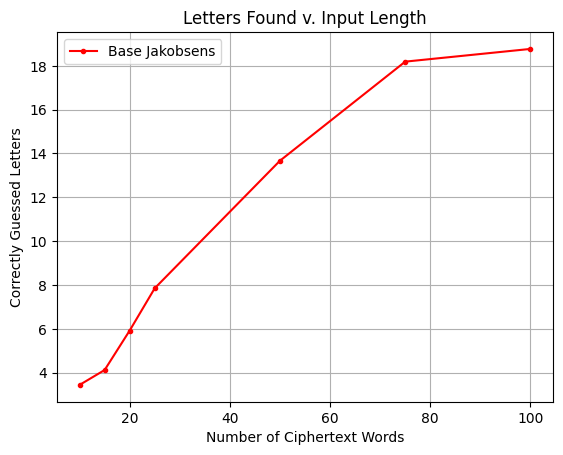

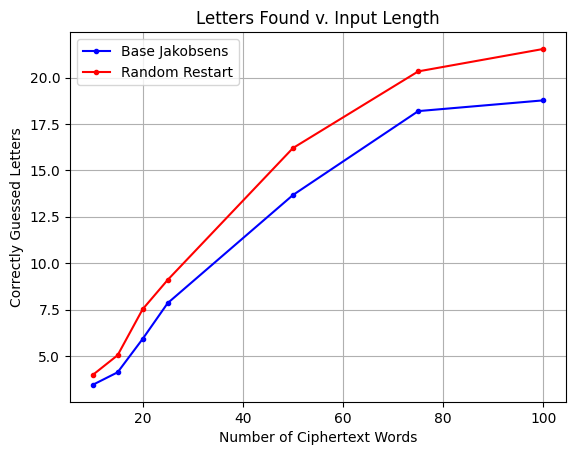

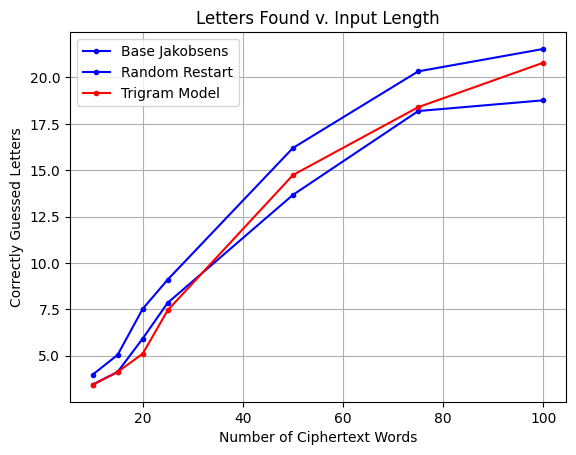

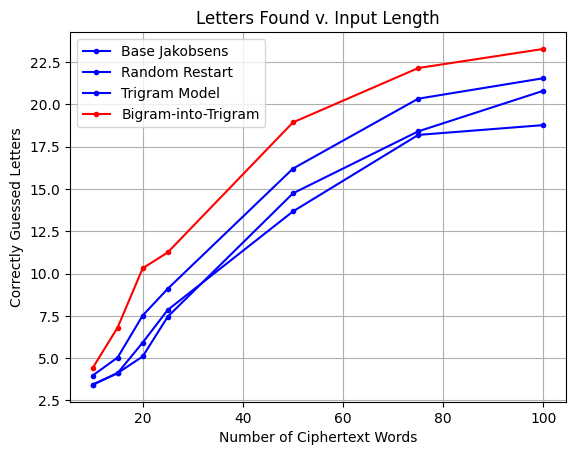

In [35]:
import matplotlib.pyplot as plt

def graphLettersSolved(wordLengths, lettersFound, lettersFoundLabels, cutoff=11): #letters, letters_spaced):

    for i in range(len(lettersFound)):
        if i == len(lettersFound)-1:
            plt.plot(wordLengths[:cutoff], lettersFound[i][:cutoff], marker = ".", linestyle = "-", label = lettersFoundLabels[i], color="red")
        else:
            plt.plot(wordLengths[:cutoff], lettersFound[i][:cutoff], marker = ".", linestyle = "-", label = lettersFoundLabels[i], color="blue")

    plt.xlabel('Number of Ciphertext Words')
    plt.ylabel('Correctly Guessed Letters')
    plt.title('Letters Found v. Input Length')
    plt.grid(True)
    plt.legend()
    plt.show()

for i in range(1, len(spacedLettersSolved)+1):
    graphLettersSolved(wordLengths, spacedLettersSolved[:i], spacedLabels[:i], 7)


In [22]:
spacedDictionaries = [formattedResultsSpacedJakobsens, formattedResultsSpacedJakobsensRandomRestart, formattedResultsSpacedTrigram]
spacedLabels = ["Jakobsens (Spaced)", "Random Restart (Spaced)", "Trigram (Spaced)"]
spacedLettersSolved = []
spacedPercentSolved = []

for resultsDict in spacedDictionaries:
    lettersSolved = []
    percentSolved = []
    for length, results in resultsDict.items():
        lettersSolved.append(results[0])
        percentSolved.append(results[1])
    spacedLettersSolved.append(lettersSolved)
    spacedPercentSolved.append(percentSolved)


spacelessDictionaries = [formattedResultsUnspacedJakobsens, formattedResultsUnspacedJakobsensRandomRestart, formattedResultsUnspacedTrigram]
spacelessLabels = ["Jakobsens (Spaceless)", "Random Restart (Spaceless)", "Trigram (Spaceless)"]

spacelessLettersSolved = []
spacelessPercentSolved = []
for resultsDict in spacelessDictionaries:
    lettersSolved = []
    percentSolved = []
    for length, results in resultsDict.items():
        lettersSolved.append(results[0])
        percentSolved.append(results[1])
    spacelessLettersSolved.append(lettersSolved)
    spacelessPercentSolved.append(percentSolved)

In [16]:
import matplotlib.pyplot as plt

def graphLettersSolved(wordLengths, lettersFound, lettersFoundLabels, cutoff=11): #letters, letters_spaced):

    for i in range(len(lettersFound)):
        plt.plot(wordLengths[:cutoff], lettersFound[i][:cutoff], marker = ".", linestyle = "-", label = lettersFoundLabels[i])
    plt.xlabel('Number of Ciphertext Words')
    plt.ylabel('Correctly Guessed Letters')
    plt.title('Letters Found v. Input Length')
    plt.grid(True)
    plt.legend()
    plt.show()

#graphLettersSolved(wordLengths, resultsLettersSolved, resultsLabels)
#graphLettersSolved(wordLengths, spacelessLettersSolved, spacelessLabels, 11)
#graphLettersSolved(wordLengths, spacedLettersSolved, spacedLabels, 11)

In [37]:
import matplotlib.pyplot as plt

def graphPlaintextSolved(wordLengths, plaintextFound, plaintextFoundLabels, cutoff=11): #letters, letters_spaced):

    for i in range(len(plaintextFound)):
        plt.plot(wordLengths[:cutoff], plaintextFound[i][:cutoff], marker = ".", linestyle='-', label = plaintextFoundLabels[i])
    plt.xlabel('Number of Ciphertext Words')
    plt.ylabel('Plaintext Decoded (%)')
    plt.title('Plaintext Found v. Input Length')
    plt.grid(True)
    plt.legend()
    plt.show()
#graphPlaintextSolved(wordLengths, resultsPercentSolved, resultsLabels)
#graphPlaintextSolved(wordLengths, spacelessPercentSolved, spacelessLabels, 8)
#graphPlaintextSolved(wordLengths, spacedPercentSolved, spacedLabels, 7)

## Returns Gained from Increasing the Number of Restarts

In [7]:
restartWordLengths = [10, 15, 20, 25, 50, 75, 100]
restartNumberOfTrials = 100


restartPlaintextSamples = {}
for length in restartWordLengths:
    print("Getting plaintext samples of length", length, end = '\r')
    restartPlaintextSamples[length] = getPlaintextSamples(length, restartNumberOfTrials)

print(str(restartNumberOfTrials) +" plaintext samples gathered for lengths", ", ".join([str(word) for word in restartWordLengths]))

100 plaintext samples gathered for lengths 10, 15, 20, 25, 50, 75, 100


In [10]:
from jakobsensAlgorithmRandomStart import testJakobsensRandomRestart
numberOfRestarts = [1, 3, 5, 10, 15]

restartTrialSpacedResults = {}

for numRestarts in numberOfRestarts:
    restartTrialSpacedResults[numRestarts] = getResultsRandomRestart(testJakobsensRandomRestart, restartPlaintextSamples, numRestarts, False, max_workers=12)

Processing trials of length 100: 100%|██████████| 100/100 [02:19<00:00,  1.40s/it]


In [13]:
formattedSpacedRestartTrialResults = {}
for numRestarts, results in restartTrialSpacedResults.items():
    formattedSpacedRestartTrialResults[numRestarts] = formatResults(results)

In [14]:
restartLabels = []
restartPlaintextSolved = []
restartLettersSolved = []

for numRestarts, resultDict in formattedSpacedRestartTrialResults.items():
    restartLabels.append(str(numRestarts) + " Restarts")
    lettersSolved = []
    percentSolved = []
    for length, results in resultDict.items():
        lettersSolved.append(results[0])
        percentSolved.append(results[1])
    restartLettersSolved.append(lettersSolved)
    restartPlaintextSolved.append(percentSolved)

graphPlaintextSolved(restartWordLengths, restartPlaintextSolved, restartLabels)

NameError: name 'graphPlaintextSolved' is not defined

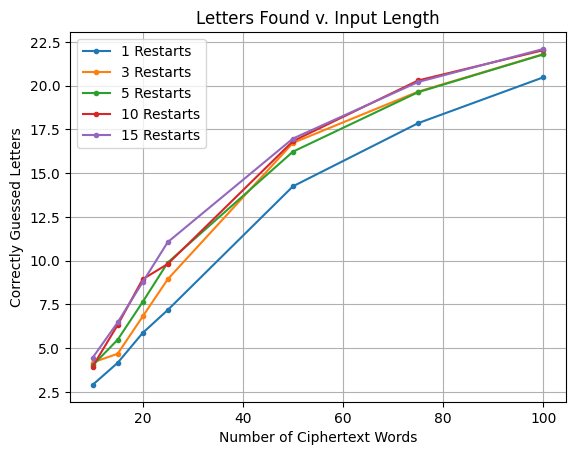

In [17]:
graphLettersSolved(restartWordLengths, restartLettersSolved, restartLabels)

# Bigram-Trigram Aware Jakobsen's Algorithm

In [28]:
biTriWordLengths = [10, 15, 20, 25, 50, 75, 100]
biTriNumberOfTrials = 100


biTriPlaintextSamples = {}
for length in biTriWordLengths:
    print("Getting plaintext samples of length", length, end = '\r')
    biTriPlaintextSamples[length] = getPlaintextSamples(length, biTriNumberOfTrials)


In [31]:
from trigramJakobsens import testJakobsensTrigramRepeatedIteration
# Helper function to get results
def getResultsBiTrigram(plaintextTests, numRestarts, spacesRemoved, max_workers=12):

    # Getting results of Jakobsen's with spaced queries
    results = {
        "InitialBigram" : {},
        "InitialTrigram" : {},
        "SecondBigram" : {},
        "SecondTrigram" : {}
    }
    executor = ProcessPoolExecutor(max_workers=max_workers)

    for length, plaintextList in plaintextTests.items():
        jobQueue = []
        results["InitialBigram"][length] = []
        results["InitialTrigram"][length] = []
        results["SecondBigram"][length] = []
        results["SecondTrigram"][length] = []

        for plaintext in plaintextList:
            jobQueue.append(executor.submit(testJakobsensTrigramRepeatedIteration, plaintext, length, numRestarts=numRestarts, spacesRemoved=spacesRemoved))

        for future in tqdm.tqdm(jobQueue, desc="Processing trials of length " + str(length)):
            initBigram, initTrigram, secondBigram, secondTrigram = future.result()
            results["InitialBigram"][length].append(initBigram)
            results["InitialTrigram"][length].append(initTrigram)
            results["SecondBigram"][length].append(secondBigram)
            results["SecondTrigram"][length].append(secondTrigram)
#    return (biLettersCorrect, biPlaintextCorrect), (triLettersCorrect, triPlaintextCorrect), (secondBiLettersCorrect, secondBiPlaintextCorrect), (secondTriLettersCorrect, secondTriPlaintextCorrect)


    executor.shutdown()
    return results

In [32]:
resultsBiTrigramSpaced = getResultsBiTrigram(biTriPlaintextSamples, 5, False, max_workers=60)

Processing trials of length 100: 100%|██████████| 100/100 [04:01<00:00,  2.41s/it] 


In [40]:
resultsBiTrigramSpaceless = getResultsBiTrigram(biTriPlaintextSamples, 5, True, max_workers=60)

Processing trials of length 100: 100%|██████████| 100/100 [01:47<00:00,  1.07s/it]


In [33]:
def formatResultsBiTri(resultsDictionary):

    formattedResultsDictionary = {}
    for stageName, subResultDictionary in resultsDictionary.items():
        formattedResultsDictionary[stageName] = {}
        for length, results in subResultDictionary.items():
            letterResults = [lettersFound for lettersFound, _ in results]
            percentResults = [percentDecoded for _, percentDecoded in results]
            formattedResultsDictionary[stageName][length] = (sum(letterResults)/len(letterResults), sum(percentResults)/len(percentResults))

    return formattedResultsDictionary

In [42]:
formattedResultsBiTriSpaced = formatResultsBiTri(resultsBiTrigramSpaced)
formattedResultsBiTriSpaceless = formatResultsBiTri(resultsBiTrigramSpaceless)

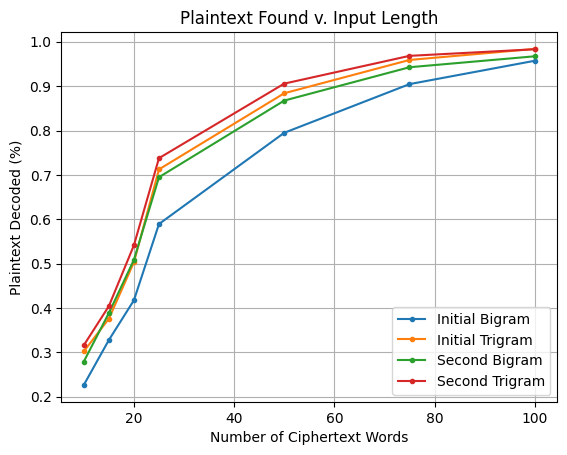

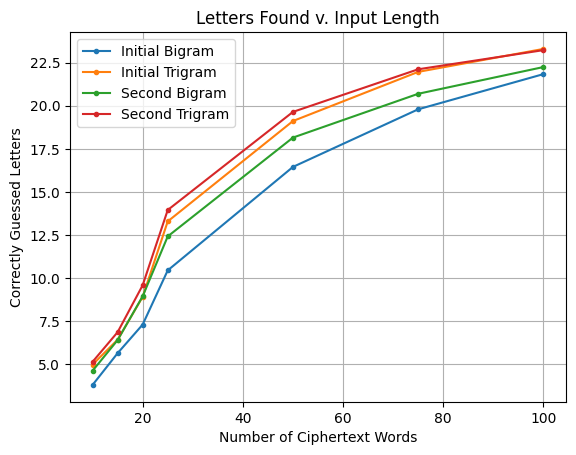

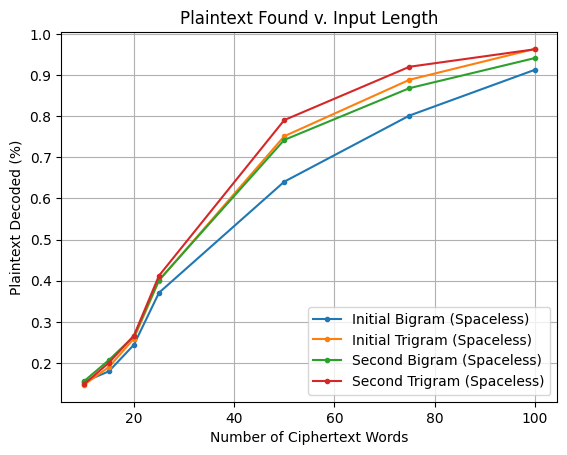

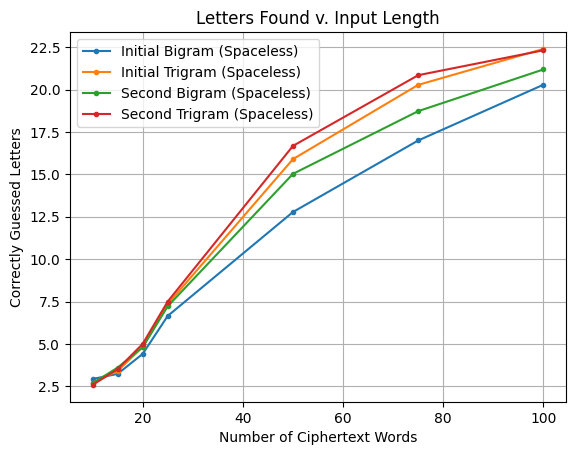

In [48]:
def displayBiTriStats(formattedResults, biTriLabels):
    biTriPlaintextSolved = []
    biTriLettersSolved = []

    for _, resultDict in formattedResults.items():
        lettersSolved = []
        percentSolved = []
        for length, results in resultDict.items():
            percentSolved.append(results[0])
            lettersSolved.append(results[1])
        biTriPlaintextSolved.append(lettersSolved)
        biTriLettersSolved.append(percentSolved)

    graphPlaintextSolved(biTriWordLengths, biTriPlaintextSolved, biTriLabels)
    graphLettersSolved(biTriWordLengths, biTriLettersSolved, biTriLabels)

displayBiTriStats(formattedResultsBiTriSpaced, ["Initial Bigram", "Initial Trigram", "Second Bigram", "Second Trigram"])
displayBiTriStats(formattedResultsBiTriSpaceless, ["Initial Bigram (Spaceless)", "Initial Trigram (Spaceless)", "Second Bigram (Spaceless)", "Second Trigram (Spaceless)"])